In [1]:
%matplotlib widget
import torch
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli
from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
from diffSPH.v2.plotUtil import plotRegionswSDF
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs, sampleNoisyParticles
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient
from diffSPH.v2.plotUtil import plotInitialParticleSampling
from diffSPH.v2.modules.neighborhood import searchNeighbors
from diffSPH.v2.plotting import visualizeParticleQuantity
from diffSPH.v2.sampling import generateRamp, sampleVelocityField
from diffSPH.v2.modules.neighborhood import searchNeighbors
from diffSPH.v2.sampling import generateRamp, getNoiseSampler
from diffSPH.v2.plotUtil import plotPotentialField
from diffSPH.v2.plotUtil import plotBoundaryParticleswGhosts
from diffSPH.v2.modules.mDBC import mDBCDensity
from diffSPH.v2.modules.boundaryViscosity import computeBoundaryVelocities
from diffSPH.v2.plotUtil import plotBoundaryVelocityFields
from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep, callModule
from diffSPH.v2.modules.density import computeDensity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles
from diffSPH.v2.modules.boundaryViscosity import computeBoundaryVelocities
from diffSPH.v2.plotUtil import plotBoundaryParticleswGhosts

In [2]:
configurationFile = './configurations/05_ldc.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)
config['boundary']['boundary_width'] = 0
config['domain']['minExtent'] = [-2.0, -1.0]
config['domain']['maxExtent'] = [5.0, 1.0]
config['domain']['periodic'] = True
config['particle']['nx'] = 64

display(config['particle'])

config['compute'] = {'device': 'cuda', 'checkNaN': True}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
config['diffusion']['alpha'] = 0.01

{'nx': 64}

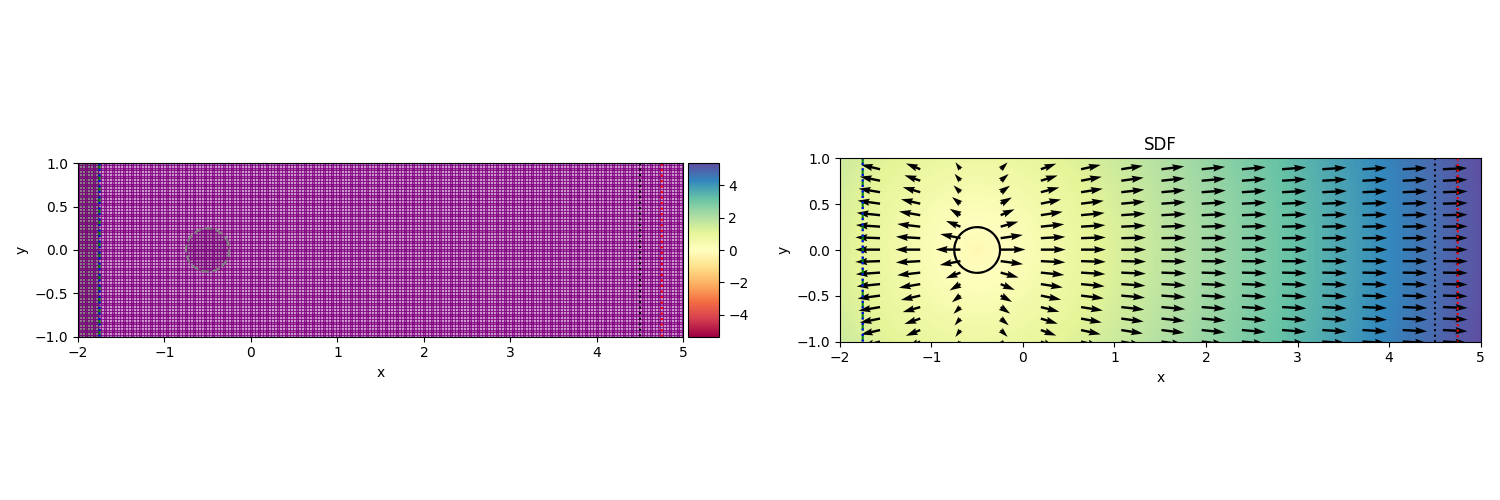

In [3]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
inletSDFa = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
inletSDF = lambda points: inletSDFa(points.cpu()).to(points.device).to(points.dtype)
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDFa = operatorDict['translate'](sphere_b, torch.tensor([5 - 1/8,0.]))
outletSDF = lambda points: outletSDFa(points.cpu()).to(points.device).to(points.dtype)
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegiona = operatorDict['translate'](sphere_b, torch.tensor([5 - 1/4,0.]))
outletRegion = lambda points: outletRegiona(points.cpu()).to(points.device).to(points.dtype)
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)



l = 0.25

inner = lambda points: getSDF('box')['function'](points, torch.tensor([0.15,0.15]).to(points.device))
boundary_sdf2 = inner# operatorDict['invert'](inner)

circle_sdf = lambda points: getSDF('circle')['function'](points, torch.tensor(l).to(points.device))
translated_sdf = operatorDict['translate'](circle_sdf, torch.tensor([-0.5,0.]))
boundary_sdf2 = lambda points: translated_sdf(points.cpu()).to(points.device)

fluidL_x = (config['domain']['maxExtent'][0] - config['domain']['minExtent'][0]) - 2 * config['particle']['dx'] * config['boundary']['boundary_width']
fluidL_y = (config['domain']['maxExtent'][1] - config['domain']['minExtent'][1]) - 2 * config['particle']['dx'] * config['boundary']['boundary_width']
fluidC_x = (config['domain']['maxExtent'][0] + config['domain']['minExtent'][0]) / 2
fluidC_y = (config['domain']['maxExtent'][1] + config['domain']['minExtent'][1]) / 2

fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([fluidL_x/2., fluidL_y/2.]).to(points.device))
fluid_sdf = operatorDict['translate'](fluid_sdf, torch.tensor([fluidC_x, fluidC_y]))

# inner = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,0.5]).to(points.device))
# outer = lambda points: getSDF('box')['function'](points, torch.tensor([0.5 + config['particle']['dx'] * config['boundary']['boundary_width'],0.5 + config['particle']['dx'] * config['boundary']['boundary_width']]).to(points.device))
# outer = operatorDict['invert'](outer)
# sdf = operatorDict['union'](inner, outer)
# boundary_sdf = operatorDict['invert'](inner)


regions = [
    {
        'sdf': inletSDF,
        'type': 'inlet',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': inletSDF,
        'type': 'forcing',
        'forcingMode': 'immediate',
        'velocity': torch.tensor([1,0.]),
        'particles': sampleParticles(config, sdfs = [inletSDF])[0],
        'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletSDF,
        'type': 'outlet',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletSDF])[0],
        'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': outletRegion,
        'type': 'mirror',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [outletRegion])[0],
        'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    # {
    #     'sdf': boundary_sdf,
    #     'type': 'boundary',
    #     'velocity': torch.tensor([0.,0.]),
    #     'kind': 'zero',
    #     'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
    #     'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf2,
        'type': 'boundary',
        'kind': 'free-slip',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [boundary_sdf2])[0],
        'contour': find_contour(boundary_sdf2(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },
    {
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

for region in config['regions']:
    if region['type'] == 'boundary':
        region['kind'] = 'free-slip'
        region['kind'] = 'none'
        # region['kind'] = 'linear'


        
plotRegionswSDF(config)

In [4]:
particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'], filter = True)
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')

perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1

perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)

perennialState['fluid']['velocities'] = torch.zeros_like(perennialState['fluid']['velocities'])
# body1 = perennialState['boundary']['bodyIDs'] == 1
# perennialState['boundary']['velocities'][body1,0] = perennialState['boundary']['positions'][body1,1] * u
# perennialState['boundary']['velocities'][body1,1] = -perennialState['boundary']['positions'][body1,0] * u

searchNeighbors(perennialState, config)
# plotInitialParticleSampling(perennialState, config)
# plotBoundaryParticleswGhosts(perennialState, config)

In [5]:
initialBoundaryState = copy.deepcopy(perennialState['boundary'])

In [6]:

from diffSPH.v2.plotting import setPlotBaseAttributes
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles

def plotBoundaryParticleswGhosts(perennialState, config):

    fig, axis = plt.subplots(2,3, figsize = (12,8), squeeze = False)

    for ax in axis.flatten():
        setPlotBaseAttributes(ax, config)

    p = perennialState['boundary']['positions'].detach().cpu().numpy()

    ghost =  buildBoundaryGhostParticles(perennialState, config)
    g = ghost['positions'].detach().cpu().numpy() 

    sc = axis[0,0].scatter(p[:,0], p[:,1], s = 1, c = perennialState['boundary']['distances'].detach().cpu().numpy())
    # sc = axis[0,0].scatter(p[:,0], p[:,1], s = 1, c = sdfValues.detach().cpu().numpy())
    fig.colorbar(sc, ax = axis[0,0])
    sc = axis[0,1].scatter(p[:,0], p[:,1], s = 1, c = perennialState['boundary']['normals'][:,0].detach().cpu().numpy(), cmap = 'magma')
    # sc = axis[0,1].scatter(p[:,0], p[:,1], s = 1, c = sdfGradients[:,0].detach().cpu().numpy())
    fig.colorbar(sc, ax = axis[0,1])
    sc = axis[0,2].scatter(p[:,0], p[:,1], s = 1, c = perennialState['boundary']['normals'][:,1].detach().cpu().numpy(), cmap = 'magma')
    # sc = axis[0,2].scatter(p[:,0], p[:,1], s = 1, c = sdfGradients[:,1].detach().cpu().numpy())
    fig.colorbar(sc, ax = axis[0,2])


    axis[1,0].scatter(p[:,0], p[:,1], s = 1, c = np.arange(p.shape[0]))
    axis[1,1].scatter(g[:,0], g[:,1], s = 1, c = np.arange(p.shape[0]))

    axis[1,2].scatter(p[:,0], p[:,1], s = 1, c = np.arange(p.shape[0]))
    axis[1,2].scatter(g[:,0], g[:,1], s = 1, c = np.arange(p.shape[0]))

    axis[0,0].set_title('Distances')
    axis[0,1].set_title('Normals x')
    axis[0,2].set_title('Normals y')

    axis[1,0].set_title('Boundary particles')
    axis[1,1].set_title('Ghost particles')
    axis[1,2].set_title('Boundary and Ghost particles')

    fig.tight_layout()


In [7]:
config['boundary']

{'active': True,
 'boundary_width': 0,
 'potentialBuffer': 5,
 'type': 'mDBC',
 'static': True,
 'twoWayCoupled': False}

In [8]:
from diffSPH.v2.sampling import rampDivergenceFree
def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 / 0.5 - 1
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped /2 + 0.5) * (noise)
def generateRamp(perennialState, regions, config):
    boundary_sdfs = [region['sdf'] for region in regions if region['type'] == 'boundary']
    combined_sdf = boundary_sdfs[0]
    for sdf in boundary_sdfs[1:]:
        combined_sdf = operatorDict['union'](combined_sdf, sdf)

    ramp = rampDivergenceFree(perennialState['positions'], torch.ones_like(perennialState['densities']), combined_sdf, offset = config['particle']['dx']/2, d0 = config['boundary']['potentialBuffer'] * perennialState['supports'])
    return ramp

config['boundary']['potentialBuffer'] = 4
ramp = generateRamp(perennialState['fluid'], regions, config)

x = perennialState['fluid']['positions']
# random sample
# noiseSampler = getNoiseSampler(config)
# potential = noiseSampler(perennialState['fluid']['positions'])
# offset TGV
potential = torch.cos(np.pi * 2 * perennialState['fluid']['positions'][:,0]) * torch.cos(np.pi * 2 * perennialState['fluid']['positions'][:,1]) / 6
# TGV Potential field
# potential = torch.sin(np.pi * 2 * perennialState['fluid']['positions'][:,0]) * torch.sin(np.pi * 2 * perennialState['fluid']['positions'][:,1]) / 6
potential[:] = - 2 * perennialState['fluid']['positions'][:,1] + 0.5
ramped = potential #* ramp
# ramped[:] = 0

filteredState = copy.deepcopy(perennialState)
filteredState['fluid']['potential'] = ramped

velocity, divergence = sampleVelocityField(filteredState['fluid'], filteredState['fluid']['neighborhood'])
u_max = torch.linalg.norm(velocity, dim = 1).max() + 1e-6
u_factor = config['fluid']['u_mag'] / u_max
# velocity = velocity * u_factor
perennialState['fluid']['velocities'] = velocity

boundary_dist = boundary_sdf2(perennialState['fluid']['positions'])
ramp = torch.clamp(boundary_dist.abs() / config['particle']['support'] / 3, max = 1.0) ** 2

perennialState['fluid']['velocities'][:,0] = 1 * ramp
perennialState['fluid']['velocities'][:,1] = 0

# plotPotentialField(perennialState, config, potential, ramped, s = 1)
# plotBoundaryVelocityFields(perennialState, config)
initialState = copy.deepcopy(perennialState)

In [9]:
perennialState.keys()

dict_keys(['fluid', 'boundary', 'time', 'timestep', 'dt', 'uidCounter', 'fluidToBoundaryNeighborhood', 'boundaryToFluidNeighborhood', 'boundaryToFluidNumNeighbors', 'fluidToBoundaryNumNeighbors'])

In [10]:
perennialState = copy.deepcopy(initialState)
perennialState['fluid']['initialPositions'] = copy.deepcopy(perennialState['fluid']['positions'])
perennialState['fluid']['pressureAccel'] = torch.zeros_like(perennialState['fluid']['velocities'])
perennialState['fluid']['densities'][:] = 1000
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= None)
rotationAngle = 0

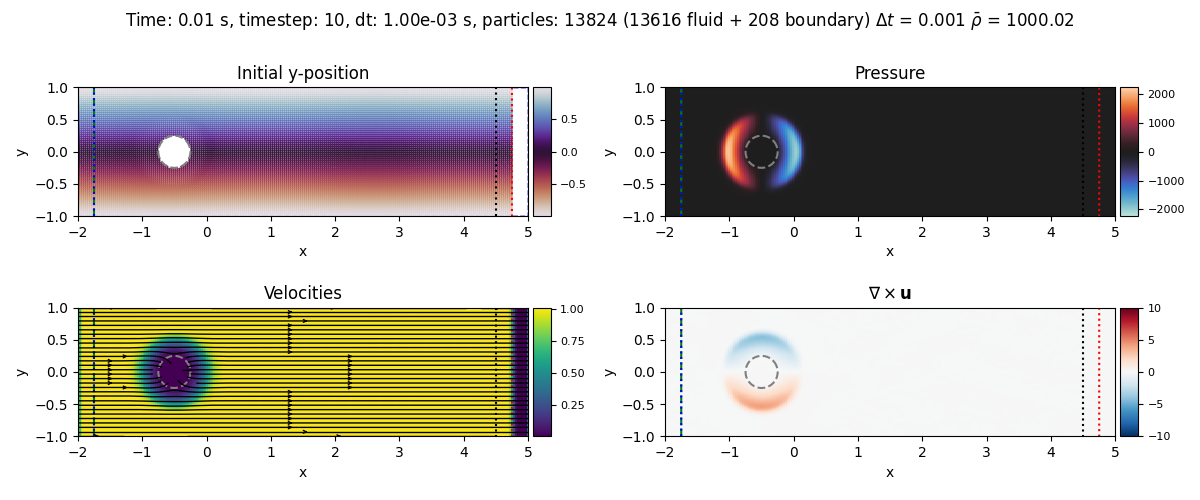

In [13]:
fig, axis = plt.subplots(2,2, figsize = (12,5), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True, nGrid = 255)
for ax in axis.flatten():
    setPlotBaseAttributes(ax, config)
    plotRegions(regions, ax, plotParticles=False)

s = 0.5

# uxPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'velocities', mapping = '.x', s = s,  scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'both', plotBoth = False, midPoint = 0)
# uyPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = '.y', s = s, scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'both', midPoint = 0)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'initialPositions', mapping = '.y', s = s, scaling = 'lin', gridVisualization=False, cmap = 'twilight_r', streamLines = False, operation = None, title = 'Initial y-position', plotBoth = False, which = 'fluid', midPoint = 1000)

pressurePlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, scaling = 'sym', gridVisualization=True, cmap = 'RdBu_r', streamLines = False, operation = 'curl', title = '$\\nabla\\times \\mathbf{u}$', plotBoth = False, which = 'fluid', midPoint = 0)
pressurePlot['cbar'].mappable.set_clim(-10,10)

shephardPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'pressures', mapping = 'L2', s = s, scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 'mean')

uPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity = 'velocities',mapping = 'L2', s = s, scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = 'Velocities', plotBoth = True, which = 'fluid', midPoint = 1000)


fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) $\\Delta t$ = {perennialState["dt"]} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')

fig.tight_layout()

In [14]:
perennialState = copy.deepcopy(initialState)
perennialState['fluid']['pressureAccel'] = torch.zeros_like(perennialState['fluid']['velocities'])
perennialState['fluid']['initialPositions'] = copy.deepcopy(perennialState['fluid']['positions'])

config["simulation"]["timestamp"] = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
from diffSPH.v2.sphOps import sphOperationStates

# priorState = None
for i in tqdm(range(4096 * 2)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    dx[perennialState['fluid']['positions'][:,0] < -1.75,:] = 0
    dx[perennialState['fluid']['positions'][:,0] > 4.5,:] = 0

    perennialState['fluid']['densities'][perennialState['fluid']['positions'][:,0] > 4.5] = config['fluid']['rho0']

    perennialState['fluid']['shiftAmount'] = dx

    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]

    # if i % 128 == 0:
    #     ones = torch.ones_like(perennialState['fluid']['positions'][:,0])
    #     ones_boundary = torch.ones_like(perennialState['boundary']['positions'][:,0])
    #     ones_interp = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (ones, ones), perennialState['fluid']['neighborhood'], operation = 'interpolate')
    #     ones_interp += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (ones, ones_boundary), perennialState['boundaryToFluidNeighborhood'], operation = 'interpolate')
    #     ones_rho = perennialState['fluid']['densities'] / ones_interp
    #     ones_rho_boundary = perennialState['boundary']['densities'] 
    #     shephard = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (ones_rho, ones_rho), perennialState['fluid']['neighborhood'], operation = 'interpolate')
    #     shephard += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (ones_rho, ones_rho_boundary), perennialState['boundaryToFluidNeighborhood'], operation = 'interpolate')
    #     shephard[perennialState['fluid']['positions'][:,0] < -1.75] = config['fluid']['rho0']
    #     shephard[perennialState['fluid']['positions'][:,0] > 4.5] = config['fluid']['rho0']

    #     perennialState['fluid']['densities'] = shephard



    # rotationAngle += perennialState['dt'] #/ np.pi

    # rotationMatrix = torch.tensor([[np.cos(rotationAngle), -np.sin(rotationAngle)], [np.sin(rotationAngle), np.cos(rotationAngle)]], device = perennialState['fluid']['positions'].device, dtype = perennialState['fluid']['positions'].dtype)  

    # perennialState['boundary']['positions'][body1,:] = torch.matmul(initialBoundaryState['positions'][body1,:], rotationMatrix)
    # perennialState['boundary']['normals'][body1,:] = torch.matmul(initialBoundaryState['normals'][body1,:], rotationMatrix)
    # perennialState['boundary']['velocities'][body1,0] = perennialState['boundary']['positions'][body1,1] * u
    # perennialState['boundary']['velocities'][body1,1] = -perennialState['boundary']['positions'][body1,0] * u

    perennialState['boundaryGhost'] = buildBoundaryGhostParticles(perennialState, config)
    perennialState['boundary']['velocities'] = computeBoundaryVelocities(perennialState, config)
    # perennialState['boundary']['velocities'][perennialState['boundary']['positions'][:,1] > 0.5 - 1e-4,0] = 1

    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1

    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) $\\Delta t$ = {perennialState["dt"]} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v}, $\\Delta t_\\text{{CFL}}$ = {dt_c}, $\\Delta t_a$ = {dt_a}')
    # print(dt_v, dt_c, dt_a)
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}')
    if i % 16 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config, grid = True, nGrid = 255)
        # updatePlot(uxPlot, visualizationState, 'velocities')
        # updatePlot(uyPlot, visualizationState, 'velocities')
        updatePlot(indexPlot, visualizationState, 'initialPositions')
        updatePlot(shephardPlot, visualizationState, 'pressures')
        updatePlot(pressurePlot, visualizationState, 'velocities')
        pressurePlot['cbar'].mappable.set_clim(-10,10)
        updatePlot(uPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in config['regions']:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, config, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/8192 [00:00<?, ?it/s]

In [15]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_10_30-18_55_03/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_10_30-18_55_03.gif'], returncode=0)

In [16]:
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -pix_fmt yuv420p -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mov'
subprocess.run(shlex.split(command))

CompletedProcess(args=['/usr/bin/ffmpeg', '-loglevel', 'warning', '-y', '-framerate', '30', '-f', 'image2', '-pattern_type', 'glob', '-i', 'output/2024_10_30-18_55_03/*.png', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', '-b:v', '20M', '-r', '30', 'output/2024_10_30-18_55_03/output.mov'], returncode=0)